In [1]:
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import inception_v3
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import models
from keras import layers
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from util.plots import plot_history

Using TensorFlow backend.


In [2]:
train_path = '../potato_and_catfood/train'
valid_path = '../potato_and_catfood/valid'
test_path = '../potato_and_catfood/test'

In [3]:
batch_size = 32

train_datagen = ImageDataGenerator(
        rescale=1./255,
        brightness_range=(0.65,1.35),
        vertical_flip=True,
        horizontal_flip=True)

valid_datagen = ImageDataGenerator(
        rescale=1./255
)

# Train data generator
train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(224, 224),
        batch_size=batch_size,
        classes=['potato', 'catfood', 'table'])

# Validation data generator
validation_generator = valid_datagen.flow_from_directory(
        valid_path,
        target_size=(224, 224),
        batch_size=batch_size,
        classes=['potato', 'catfood', 'table'])

# this is a similar generator, for validation data
test_generator = valid_datagen.flow_from_directory(
        test_path,
        target_size=(224, 224),
        batch_size=batch_size,
        classes=['potato', 'catfood', 'table'])

Found 446 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
Found 35 images belonging to 3 classes.


In [4]:
base_model = inception_v3.InceptionV3(include_top=False, weights='imagenet', input_shape=(224,224, 3))

In [5]:
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer
predictions = Dense(3, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [6]:
history1 = model.fit_generator(
              train_generator,
              steps_per_epoch=446 // batch_size,
              epochs=20,
              validation_data=validation_generator,
              validation_steps= 150 // batch_size)

Epoch 1/20
13/13 [==============================] - 9s 675ms/step - loss: 0.8441 - acc: 0.6288 - val_loss: 0.7045 - val_acc: 0.6328
Epoch 2/20
13/13 [==============================] - 7s 523ms/step - loss: 0.4846 - acc: 0.8745 - val_loss: 0.7623 - val_acc: 0.5593
Epoch 3/20
13/13 [==============================] - 6s 500ms/step - loss: 0.3203 - acc: 0.9279 - val_loss: 0.3736 - val_acc: 0.8475
Epoch 4/20
13/13 [==============================] - 6s 469ms/step - loss: 0.2951 - acc: 0.9173 - val_loss: 0.6604 - val_acc: 0.7542
Epoch 5/20
13/13 [==============================] - 6s 438ms/step - loss: 0.2150 - acc: 0.9468 - val_loss: 0.5198 - val_acc: 0.8136
Epoch 6/20
13/13 [==============================] - 6s 473ms/step - loss: 0.2197 - acc: 0.9494 - val_loss: 0.4760 - val_acc: 0.8359
Epoch 7/20
13/13 [==============================] - 7s 504ms/step - loss: 0.1944 - acc: 0.9467 - val_loss: 0.4213 - val_acc: 0.8475
Epoch 8/20
13/13 [==============================] - 6s 448ms/step - loss: 0.

In [7]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy')

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
history2 = model.fit_generator(
              train_generator,
              steps_per_epoch=446 // batch_size,
              epochs=50,
              validation_data=validation_generator,
              validation_steps= 150 // batch_size)

Epoch 1/50
13/13 [==============================] - 10s 744ms/step - loss: 0.1300 - val_loss: 0.5613
Epoch 2/50
13/13 [==============================] - 8s 582ms/step - loss: 0.1103 - val_loss: 0.5419
Epoch 3/50
13/13 [==============================] - 9s 664ms/step - loss: 0.1023 - val_loss: 0.4916
Epoch 4/50
13/13 [==============================] - 8s 587ms/step - loss: 0.0922 - val_loss: 0.4460
Epoch 5/50
13/13 [==============================] - 7s 516ms/step - loss: 0.0863 - val_loss: 0.4198
Epoch 6/50
13/13 [==============================] - 8s 614ms/step - loss: 0.0951 - val_loss: 0.4429
Epoch 7/50
13/13 [==============================] - 8s 598ms/step - loss: 0.0924 - val_loss: 0.3861
Epoch 8/50
13/13 [==============================] - 7s 562ms/step - loss: 0.1084 - val_loss: 0.3192
Epoch 9/50
13/13 [==============================] - 7s 536ms/step - loss: 0.0695 - val_loss: 0.3980
Epoch 10/50
13/13 [==============================] - 7s 501ms/step - loss: 0.0852 - val_loss: 0.392

<b>Plot</b>

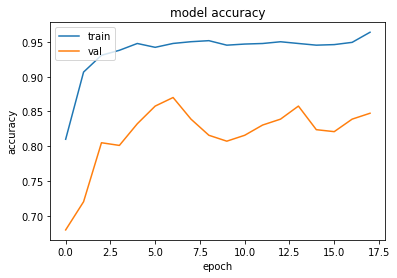

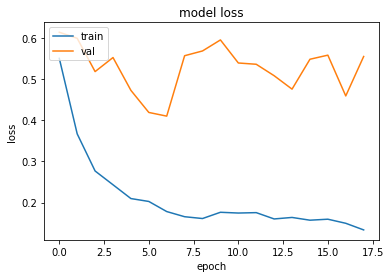

In [8]:
plot_history(history1, mean_N=3)

In [9]:
plot_history(history2, mean_N=3)

KeyError: 'acc'

<Figure size 432x288 with 0 Axes>

In [ ]:
imgs, labels = next(validation_generator)

model.evaluate(imgs,labels, batch_size=batch_size)